# LogRatioEstimator_Ndim

First we need some imports.

In [558]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [484]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
import dynesty

In [532]:
N = 3000  # Number of samples
D = 10
z = np.random.rand(N, D)*2 - 1

In [533]:
#z = prop

In [541]:
x = z + np.random.randn(N, D)*0.1

In [542]:
samples = swyft.Samples(x = x.astype(np.float32), z = z.astype(np.float32))

In [543]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        marginals = (tuple(range(D)),)
#        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 3, varnames = 'z')
        self.logratios2 = swyft.LogRatioEstimator_Ndim(num_features = D, marginals = marginals,
                varnames = 'z', hidden_features = 256, num_blocks = 2, dropout = 0.1, Lmax = 0)
        self.optimizer_init = swyft.OptimizerInit(torch.optim.Adam, dict(lr = 1e-4))
#              torch.optim.lr_scheduler.ReduceLROnPlateau, dict(factor = 0.3, patience=5))

    def forward(self, A, B):
#        z = B['z']
        #zf = [z.unsqueeze(-1), torch.sin(z), torch.cos(z)]
        #zf = torch.cat(zf, dim=-1)
        #print(zf.shape)
        #logratios1 = self.logratios1(A['x'], B['z'])
        logratios2 = self.logratios2(A['x'], B['z'])
        return logratios2

In [544]:
# p(z_1|x),  p(z_2|x, z_1) * p(z_3|x, s(z_1, z_2))

In [545]:
# p(z_i|x, s_i(z without z_i)) compare with p(z_i|x)

In [546]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = D*2, num_params = D, varnames = 'z')
        self.optimizer_init = swyft.OptimizerInit(torch.optim.Adam, dict(lr = 1e-3))

    def forward(self, A, B):
        z = B['z']
        x = A['x']
        zA = A['z']
        x, z = swyft.equalize_tensors(x, z)
        x, zA = swyft.equalize_tensors(x, zA)
        f = torch.cat([x, zA], dim=-1)
        f = f.unsqueeze(1)
        f = f.repeat((1, D, 1))
        mask = torch.ones(D, D*2)
        for i in range(D):
            mask[i, -D+i:] = 0
        f = f*mask
        logratios1 = self.logratios1(f, z)
        return logratios1

In [547]:
trainer = swyft.SwyftTrainer(accelerator = 'cpu', devices=1, max_epochs = 10, precision = 32)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [548]:
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.1, 0.1], num_workers = 0, batch_size = 32)

In [549]:
network = Network()

In [550]:
trainer.fit(network, dm)


  | Name       | Type                   | Params
------------------------------------------------------
0 | logratios1 | LogRatioEstimator_1dim | 186 K 
------------------------------------------------------
186 K     Trainable params
0         Non-trainable params
186 K     Total params
0.745     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [551]:
#B = swyft.Samples(z = np.random.rand(100000, D).astype(np.float32)*2-1)

In [552]:
network.train(False);

In [553]:
#A = swyft.Sample(x = torch.tensor(np.array([[x0]]).astype(np.float32)))
def loglike(u):
    B = swyft.Samples(z = torch.tensor(np.array([u]).astype(np.float32)))
    A = swyft.Sample(x = torch.zeros((1,D)), z=B['z'])
    pred = network(A, B)
    lnL = pred.logratios.sum().item()
    return lnL

In [554]:
#def loglike(u):
#    lnL = 0.5*sum(-u**2/0.1**2)+5
#    return lnL

In [555]:
def prior_transform(u):
    return u*2-1

In [556]:
sampler = dynesty.NestedSampler(loglike, prior_transform, D,
                                       bound='multi', sample='rwalk', nlive = 1000, )#, live_points = [u, v, logl])

In [557]:
sampler.run_nested(maxcall=10000000, logl_max = -10, print_progress=True)


0it [00:00, ?it/s]
153it [00:00, 1517.72it/s, bound: 0 | nc: 3 | ncall: 1167 | eff(%): 13.111 | loglstar:   -inf < -56.093 < -10.000 | logz: -60.006 +/-  0.055 | dlogz: 56.540 >  1.009]
305it [00:00, 1407.69it/s, bound: 0 | nc: 2 | ncall: 1366 | eff(%): 22.328 | loglstar:   -inf < -50.903 < -10.000 | logz: -54.579 +/-  0.052 | dlogz: 50.948 >  1.009]
447it [00:00, 1302.50it/s, bound: 0 | nc: 1 | ncall: 1570 | eff(%): 28.471 | loglstar:   -inf < -47.670 < -10.000 | logz: -51.134 +/-  0.050 | dlogz: 47.352 >  1.009]
579it [00:00, 1155.68it/s, bound: 0 | nc: 3 | ncall: 1810 | eff(%): 31.989 | loglstar:   -inf < -45.329 < -10.000 | logz: -48.681 +/-  0.049 | dlogz: 44.763 >  1.009]
697it [00:00, 1073.45it/s, bound: 0 | nc: 3 | ncall: 2037 | eff(%): 34.217 | loglstar:   -inf < -43.674 < -10.000 | logz: -46.999 +/-  0.048 | dlogz: 42.961 >  1.009]
806it [00:00, 930.63it/s, bound: 0 | nc: 1 | ncall: 2294 | eff(%): 35.135 | loglstar:   -inf < -41.943 < -10.000 | logz: -45.411 +/-  0.049 | dlo

-9.997467041015625 9.546506881713867


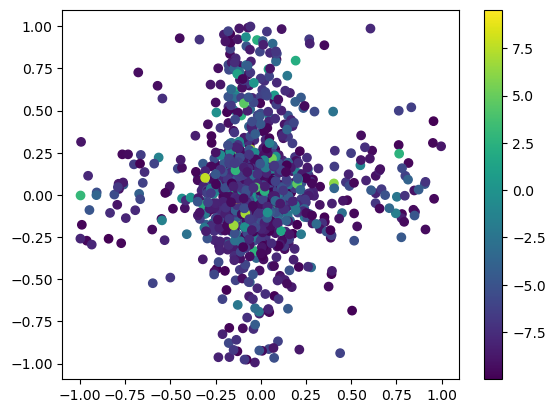

In [517]:
u = sampler.live_u
v = sampler.live_v
logl = sampler.live_logl
print(logl.min(), logl.max())
plt.scatter(v[:,0], v[:,1], c = logl)
plt.colorbar()

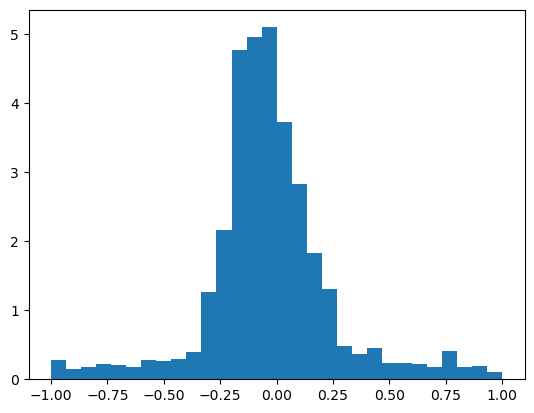

In [521]:
logl = sampler.results.logwt
u = sampler.results.samples_u*2-1
plt.hist(u[:,0], weights = np.exp(logl*0.2), bins = 30);

In [470]:
(sum(u[:,0]**2*np.exp(logl))/sum(np.exp(logl)))**0.5

0.11275677670788001

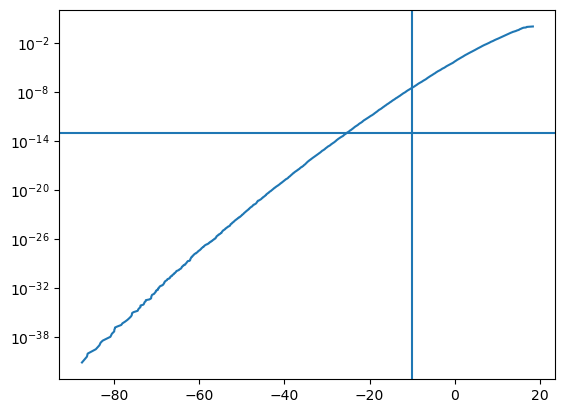

In [471]:
logl = sampler.results.logl
logwt = sampler.results.logwt
wt = np.exp(logwt-logwt.max())
wt = wt/wt.sum()
wtc = np.cumsum(wt)
plt.semilogy(logl, wtc)
plt.axhline(1e-13)
plt.axvline(-10)

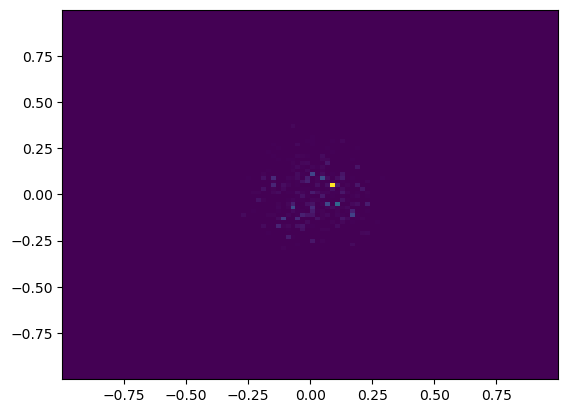

In [472]:
plt.hist2d(u[:,0], u[:,1], weights = np.exp(logl), bins = 100);

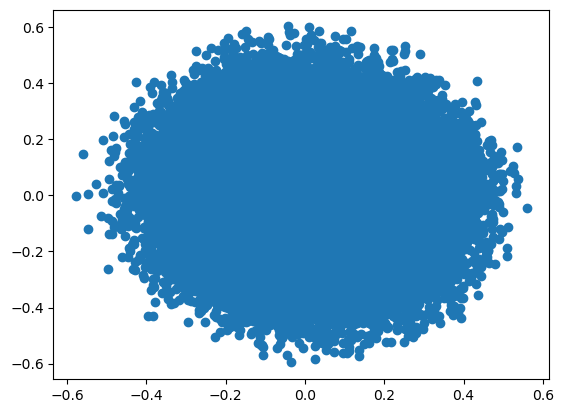

In [473]:
sampler.update()
prop = np.array([sampler.propose_unif()[0] for _ in range(30000)])*2-1
plt.scatter(prop[:,0], prop[:,1])